In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
from torchvision import datasets,transforms
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import imageio

In [2]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
DATA_DIR = "data"

In [36]:
PROCESS_DATA = 1
TRAINING_DATA = 0

In [5]:
IMG_SIZE = 128
BATCH_SIZE = 64
LATENT_SIZE = 100

In [6]:
data_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.CenterCrop((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
if PROCESS_DATA:
    dataset = datasets.ImageFolder(DATA_DIR, transform= data_transform)
    dataloader = data.DataLoader(dataset,batch_size=BATCH_SIZE, num_workers=4, shuffle=True)

In [8]:
#Show data size
print(len(dataset))

150000


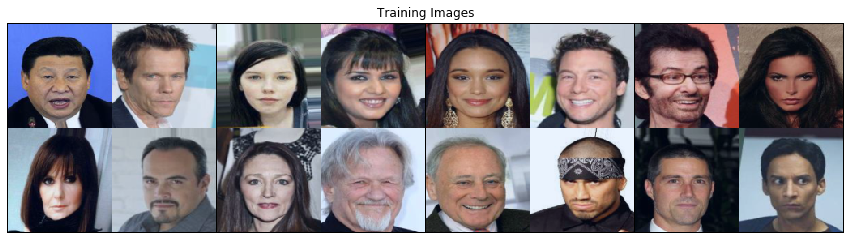

In [9]:
#Visualize some training data
def visualize_data(dataloader, NUM_PIC=16):
    a = np.random.randint(BATCH_SIZE-NUM_PIC)
    fig = plt.figure(figsize=(15,15))
    img = next(iter(dataloader))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(img[0][a:a+NUM_PIC],padding=1, normalize=True),(1,2,0)))
    plt.show()

visualize_data(dataloader)

In [10]:
#Make random latent noise vector
def random_noise(size):
    noise = torch.randn(size, LATENT_SIZE, 1 , 1)
    return Variable(noise).to(device)

In [11]:
#Generate truth or false label
def generate_label(size,label):
    if label:
        data = torch.ones(size,1) - 0.1 #Smooth label one-side
    else:
        data = torch.zeros(size,1)
    return Variable(data).view(-1).to(device)

In [12]:
#Inititate weights for Generator and Discriminator with mean = 0.02, standard deviation = 1
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            #Input latent: 100*1
            nn.ConvTranspose2d(100,128*8,4,1,0),
            nn.BatchNorm2d(128*8),
            nn.ReLU(True),
            #Output shape: (128*8)*4*4
            
            nn.ConvTranspose2d(128*8,128*4,4,2,1),
            nn.BatchNorm2d(128*4),
            nn.ReLU(True),
            #Output shape: (128*4)*8*8
            
            nn.ConvTranspose2d(128*4,128*2,4,2,1),
            nn.BatchNorm2d(128*2),
            nn.ReLU(True),
            #Output shape: (128*2)*16*16
            
            nn.ConvTranspose2d(128*2,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            #Output shape: (128)*32*32
            
            nn.ConvTranspose2d(128,64,4,2,1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            #Output shape: (64)*64*64
            
            nn.ConvTranspose2d(64,3,4,2,1),
            nn.Tanh()
            #Output shape: 3*128*128
        )
    def forward(self, x):
        x = self.main(x)
        return x

In [14]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #Input shape: 3*128*128
            
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            #Output shape: (64)*64*64
         
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            #Output shape: 128*32*32
            
        
            nn.Conv2d(128, 128*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128*2),
            nn.LeakyReLU(0.2, inplace=True),
            #Output shape: (128*2)*16*16
            
            nn.Conv2d(128*2, 128*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128*4),
            nn.LeakyReLU(0.2, inplace=True),
            #Output shape: (128*4)*8*8
            
            nn.Conv2d(128*4, 128*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128*8),
            nn.LeakyReLU(0.2, inplace=True),
            #Output shape: (128*8)*4*4
            )
        self.main2 = nn.Sequential( 
            nn.Conv2d(128*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            
        )

    def forward(self, x):
        x = self.main(x)
        x = self.main2(x)
       
        return x

In [15]:
#Train the discriminator
def train_discriminator(D, D_optimizer, error, real_data, fake_data):
    batch_size = real_data.size(0)
    D_optimizer.zero_grad()
    
    #Training on all real data
    real_data = real_data.to(device)
    predict_real = D(real_data).view(-1)
    real_label = generate_label(batch_size, 1)
  
    loss_real = error(predict_real,real_label)
    loss_real.backward()
    
    
    #Training on all fake data
    fake_data = fake_data.to(device)
    predict_fake = D(fake_data).view(-1)
    fake_label = generate_label(batch_size, 0)
    loss_fake = error(predict_fake, fake_label)
    loss_fake.backward()
    
    D_x = predict_real.mean().item()
    D_g_z1 = predict_fake.mean().item()
    
    D_optimizer.step()
    
    return loss_real.data+loss_fake.data, D_x, D_g_z1
    

In [16]:
#Train the generator
def train_generator(D, G_optimizer, error, fake_data):
    batch_size = fake_data.size(0)
    G_optimizer.zero_grad()
    fake_data = fake_data.to(device)
    predict = D(fake_data).view(-1)
    real_label = generate_label(batch_size, 1)
    loss = error(predict, real_label)
    loss.backward()
    G_optimizer.step()
    D_g_z2 = predict.mean().item()
    return loss.data, D_g_z2

In [27]:
#Generate some samples
def generate_samples(G, noise):
    G.eval()
    with torch.no_grad():
        fig = plt.figure(figsize=(30,30))
        generated = G(noise).detach().view(-1,3,IMG_SIZE,IMG_SIZE).cpu()
        img = np.transpose(torchvision.utils.make_grid(generated[:],padding =1, normalize=True),(1,2,0))
        plt.imshow(img)
        plt.axis("off")
        plt.title("Generated Images")
        plt.show()
    G.train()
    return img

In [18]:
#Generate fixed test noise
test_noise = random_noise(16)

In [19]:
#Start training process
def train(D, G, D_optimizer, G_optimizer, error, dataloader):
    EPOCHS = 30
    D_loss_list = []
    G_loss_list = []
    img_list = []
    print("Start Training.....")
    for epoch in range(EPOCHS):
        for i, (real_batch,_) in enumerate(dataloader):
            #First train the Discriminator
            batch_size = real_batch.size(0)
            real_data = Variable(real_batch.view(-1,3,IMG_SIZE,IMG_SIZE))
            fake_data = G(random_noise(batch_size)).detach()
            D_loss, D_x, D_g_z1 = train_discriminator(D, D_optimizer, error, real_data, fake_data)
            
            #Then train the Generator
            data = G(random_noise(batch_size))
            G_loss, D_g_z2 = train_generator(D, G_optimizer, error, data)
            
            D_loss_list.append(D_loss)
            G_loss_list.append(G_loss)
            
            if i%500 ==0 or i ==len(dataloader)-1:
                print("Epoch: ({}/{}), Batch: ({}/{}), D_Loss: {:.4f}, G_Loss: {:.4f}, D(x): {:.4f}, G(D(z)): {:.4f} / {:.4f}".format(epoch+1,EPOCHS,i+1,len(dataloader),D_loss,G_loss,D_x, D_g_z1,D_g_z2))
        torch.save(G.state_dict(), "model/generator3.pth")
        torch.save(D.state_dict(), "model/discriminator3.pth")
        if epoch%3==0 or epoch == EPOCHS-1:
            img = generate_samples(G, test_noise)
            img_list.append(img)
    print("Training Completed!")
    return G, D_loss_list, G_loss_list, img_list

Start Training.....
Epoch: (1/30), Batch: (1/2344), D_Loss: 2.0135, G_Loss: 14.2300, D(x): 0.6416, G(D(z)): 0.6220 / 0.0000
Epoch: (1/30), Batch: (501/2344), D_Loss: 1.8303, G_Loss: 7.1028, D(x): 0.8920, G(D(z)): 0.6706 / 0.0007
Epoch: (1/30), Batch: (1001/2344), D_Loss: 0.9127, G_Loss: 4.0684, D(x): 0.7253, G(D(z)): 0.3268 / 0.0188
Epoch: (1/30), Batch: (1501/2344), D_Loss: 0.7304, G_Loss: 3.3376, D(x): 0.6436, G(D(z)): 0.1165 / 0.0392
Epoch: (1/30), Batch: (2001/2344), D_Loss: 0.8352, G_Loss: 1.8023, D(x): 0.6210, G(D(z)): 0.1370 / 0.1814
Epoch: (1/30), Batch: (2344/2344), D_Loss: 0.9156, G_Loss: 3.2513, D(x): 0.6064, G(D(z)): 0.2331 / 0.0483


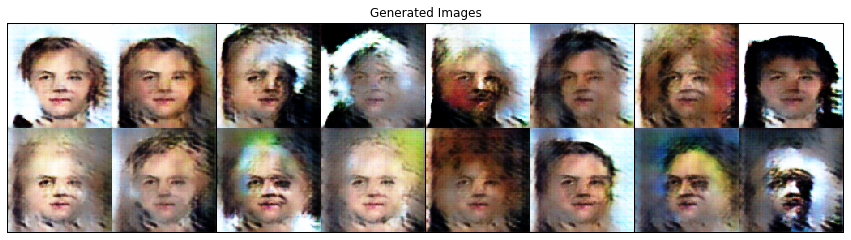

Epoch: (2/30), Batch: (1/2344), D_Loss: 0.8442, G_Loss: 2.6937, D(x): 0.6216, G(D(z)): 0.1921 / 0.0761
Epoch: (2/30), Batch: (501/2344), D_Loss: 0.6694, G_Loss: 2.2530, D(x): 0.6661, G(D(z)): 0.0980 / 0.1243
Epoch: (2/30), Batch: (1001/2344), D_Loss: 1.1621, G_Loss: 4.2855, D(x): 0.8857, G(D(z)): 0.4932 / 0.0139
Epoch: (2/30), Batch: (1501/2344), D_Loss: 0.9437, G_Loss: 3.2179, D(x): 0.7582, G(D(z)): 0.3322 / 0.0426
Epoch: (2/30), Batch: (2001/2344), D_Loss: 0.9316, G_Loss: 3.3408, D(x): 0.7455, G(D(z)): 0.3692 / 0.0400
Epoch: (2/30), Batch: (2344/2344), D_Loss: 0.7290, G_Loss: 2.1137, D(x): 0.6807, G(D(z)): 0.1626 / 0.1171
Epoch: (3/30), Batch: (1/2344), D_Loss: 0.8167, G_Loss: 1.7992, D(x): 0.7288, G(D(z)): 0.2845 / 0.1866
Epoch: (3/30), Batch: (501/2344), D_Loss: 0.8498, G_Loss: 2.1094, D(x): 0.6348, G(D(z)): 0.2213 / 0.1307
Epoch: (3/30), Batch: (1001/2344), D_Loss: 1.2167, G_Loss: 1.6953, D(x): 0.3515, G(D(z)): 0.0562 / 0.2124
Epoch: (3/30), Batch: (1501/2344), D_Loss: 1.0090, G_L

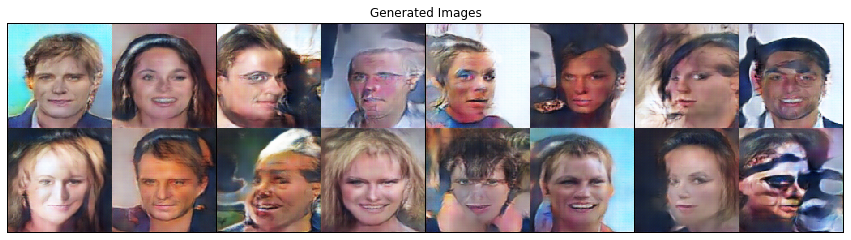

Epoch: (5/30), Batch: (1/2344), D_Loss: 1.0598, G_Loss: 1.1820, D(x): 0.4929, G(D(z)): 0.1663 / 0.3555
Epoch: (5/30), Batch: (501/2344), D_Loss: 0.7607, G_Loss: 3.2032, D(x): 0.8206, G(D(z)): 0.2762 / 0.0463
Epoch: (5/30), Batch: (1001/2344), D_Loss: 1.0721, G_Loss: 1.2318, D(x): 0.4220, G(D(z)): 0.0798 / 0.3084
Epoch: (5/30), Batch: (1501/2344), D_Loss: 0.9239, G_Loss: 0.7909, D(x): 0.4979, G(D(z)): 0.0917 / 0.5186
Epoch: (5/30), Batch: (2001/2344), D_Loss: 0.8917, G_Loss: 3.5577, D(x): 0.9137, G(D(z)): 0.3642 / 0.0327
Epoch: (5/30), Batch: (2344/2344), D_Loss: 1.1056, G_Loss: 1.0712, D(x): 0.5752, G(D(z)): 0.3336 / 0.4074
Epoch: (6/30), Batch: (1/2344), D_Loss: 0.9369, G_Loss: 1.6911, D(x): 0.7397, G(D(z)): 0.3398 / 0.2287
Epoch: (6/30), Batch: (501/2344), D_Loss: 0.6359, G_Loss: 2.2422, D(x): 0.7057, G(D(z)): 0.1307 / 0.1174
Epoch: (6/30), Batch: (1001/2344), D_Loss: 0.5137, G_Loss: 2.6555, D(x): 0.7570, G(D(z)): 0.0569 / 0.0799
Epoch: (6/30), Batch: (1501/2344), D_Loss: 0.6037, G_L

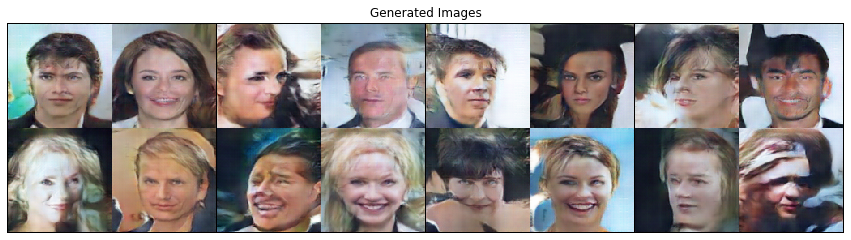

Epoch: (8/30), Batch: (1/2344), D_Loss: 0.4302, G_Loss: 4.5212, D(x): 0.9330, G(D(z)): 0.0397 / 0.0109
Epoch: (8/30), Batch: (501/2344), D_Loss: 0.5620, G_Loss: 2.3729, D(x): 0.6903, G(D(z)): 0.0499 / 0.1121
Epoch: (8/30), Batch: (1001/2344), D_Loss: 0.6596, G_Loss: 2.3463, D(x): 0.6138, G(D(z)): 0.0521 / 0.1005
Epoch: (8/30), Batch: (1501/2344), D_Loss: 1.4109, G_Loss: 5.3675, D(x): 0.9834, G(D(z)): 0.5184 / 0.0059
Epoch: (8/30), Batch: (2001/2344), D_Loss: 0.4244, G_Loss: 3.6018, D(x): 0.8302, G(D(z)): 0.0373 / 0.0309
Epoch: (8/30), Batch: (2344/2344), D_Loss: 0.5135, G_Loss: 2.2781, D(x): 0.8198, G(D(z)): 0.1153 / 0.1137
Epoch: (9/30), Batch: (1/2344), D_Loss: 0.5322, G_Loss: 4.4253, D(x): 0.9185, G(D(z)): 0.1430 / 0.0122
Epoch: (9/30), Batch: (501/2344), D_Loss: 0.4140, G_Loss: 3.8734, D(x): 0.8677, G(D(z)): 0.0442 / 0.0205
Epoch: (9/30), Batch: (1001/2344), D_Loss: 0.5487, G_Loss: 2.7812, D(x): 0.8222, G(D(z)): 0.1230 / 0.0732
Epoch: (9/30), Batch: (1501/2344), D_Loss: 0.5385, G_L

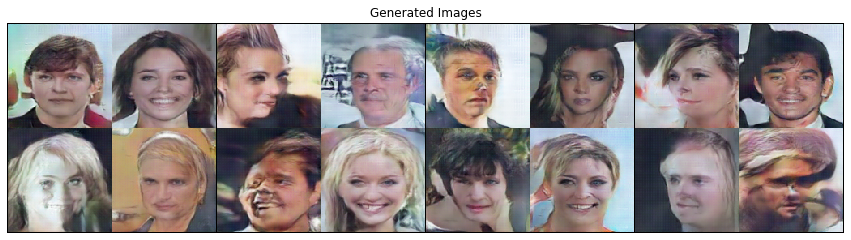

Epoch: (11/30), Batch: (1/2344), D_Loss: 0.7258, G_Loss: 1.1788, D(x): 0.5850, G(D(z)): 0.0694 / 0.3750
Epoch: (11/30), Batch: (501/2344), D_Loss: 0.7311, G_Loss: 1.2778, D(x): 0.5518, G(D(z)): 0.0140 / 0.3215
Epoch: (11/30), Batch: (1001/2344), D_Loss: 0.6009, G_Loss: 1.6208, D(x): 0.6201, G(D(z)): 0.0077 / 0.2189
Epoch: (11/30), Batch: (1501/2344), D_Loss: 0.4449, G_Loss: 2.8881, D(x): 0.9014, G(D(z)): 0.0645 / 0.0575
Epoch: (11/30), Batch: (2001/2344), D_Loss: 0.4117, G_Loss: 3.3088, D(x): 0.8321, G(D(z)): 0.0247 / 0.0361
Epoch: (11/30), Batch: (2344/2344), D_Loss: 0.7619, G_Loss: 9.2293, D(x): 0.8497, G(D(z)): 0.2866 / 0.0001
Epoch: (12/30), Batch: (1/2344), D_Loss: 0.7830, G_Loss: 4.5949, D(x): 0.4965, G(D(z)): 0.0003 / 0.0196
Epoch: (12/30), Batch: (501/2344), D_Loss: 0.5359, G_Loss: 5.0687, D(x): 0.6977, G(D(z)): 0.0217 / 0.0078
Epoch: (12/30), Batch: (1001/2344), D_Loss: 1.1260, G_Loss: 5.6080, D(x): 0.9953, G(D(z)): 0.3884 / 0.0032
Epoch: (12/30), Batch: (1501/2344), D_Loss: 0

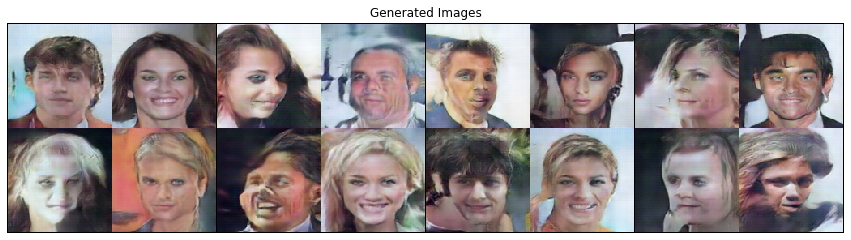

Epoch: (14/30), Batch: (1/2344), D_Loss: 0.4239, G_Loss: 3.3463, D(x): 0.8197, G(D(z)): 0.0300 / 0.0433
Epoch: (14/30), Batch: (501/2344), D_Loss: 0.3841, G_Loss: 4.4094, D(x): 0.9377, G(D(z)): 0.0086 / 0.0118
Epoch: (14/30), Batch: (1001/2344), D_Loss: 0.4165, G_Loss: 3.9040, D(x): 0.8626, G(D(z)): 0.0531 / 0.0198
Epoch: (14/30), Batch: (1501/2344), D_Loss: 0.7194, G_Loss: 4.1688, D(x): 0.9604, G(D(z)): 0.2575 / 0.0149
Epoch: (14/30), Batch: (2001/2344), D_Loss: 0.4147, G_Loss: 2.9177, D(x): 0.7808, G(D(z)): 0.0094 / 0.0553
Epoch: (14/30), Batch: (2344/2344), D_Loss: 0.8695, G_Loss: 2.9154, D(x): 0.9394, G(D(z)): 0.3261 / 0.0647
Epoch: (15/30), Batch: (1/2344), D_Loss: 0.5405, G_Loss: 2.6820, D(x): 0.7963, G(D(z)): 0.0977 / 0.0772
Epoch: (15/30), Batch: (501/2344), D_Loss: 0.5491, G_Loss: 1.8443, D(x): 0.6882, G(D(z)): 0.0270 / 0.1886
Epoch: (15/30), Batch: (1001/2344), D_Loss: 0.5917, G_Loss: 3.7416, D(x): 0.9587, G(D(z)): 0.1531 / 0.0297
Epoch: (15/30), Batch: (1501/2344), D_Loss: 1

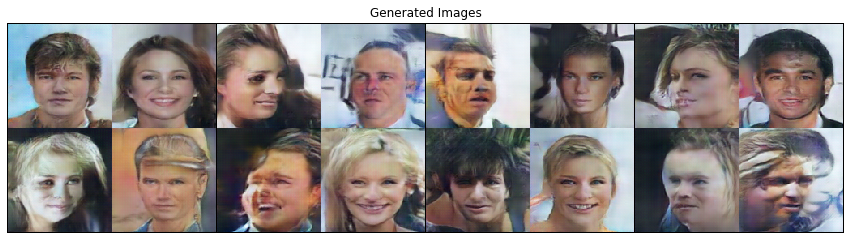

Epoch: (17/30), Batch: (1/2344), D_Loss: 1.3710, G_Loss: 6.5561, D(x): 0.9847, G(D(z)): 0.5442 / 0.0011
Epoch: (17/30), Batch: (501/2344), D_Loss: 0.9649, G_Loss: 4.3523, D(x): 0.9877, G(D(z)): 0.3440 / 0.0117
Epoch: (17/30), Batch: (1001/2344), D_Loss: 0.4991, G_Loss: 2.6666, D(x): 0.7036, G(D(z)): 0.0273 / 0.0703
Epoch: (17/30), Batch: (1501/2344), D_Loss: 0.3790, G_Loss: 5.6789, D(x): 0.9402, G(D(z)): 0.0216 / 0.0029
Epoch: (17/30), Batch: (2001/2344), D_Loss: 0.4035, G_Loss: 3.5791, D(x): 0.8591, G(D(z)): 0.0396 / 0.0298
Epoch: (17/30), Batch: (2344/2344), D_Loss: 0.4020, G_Loss: 3.6980, D(x): 0.8536, G(D(z)): 0.0335 / 0.0233
Epoch: (18/30), Batch: (1/2344), D_Loss: 0.4769, G_Loss: 2.1024, D(x): 0.7326, G(D(z)): 0.0205 / 0.1505
Epoch: (18/30), Batch: (501/2344), D_Loss: 0.5396, G_Loss: 4.7387, D(x): 0.9604, G(D(z)): 0.1250 / 0.0088
Epoch: (18/30), Batch: (1001/2344), D_Loss: 0.3839, G_Loss: 3.1973, D(x): 0.8867, G(D(z)): 0.0252 / 0.0444
Epoch: (18/30), Batch: (1501/2344), D_Loss: 0

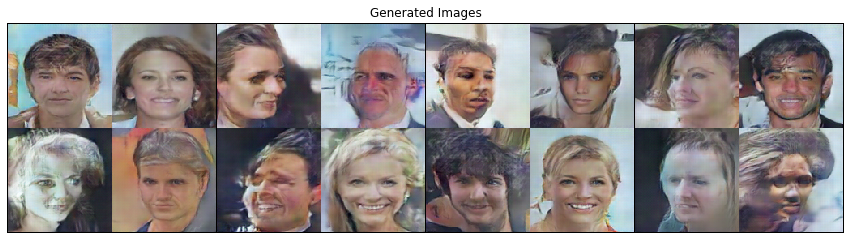

Epoch: (20/30), Batch: (1/2344), D_Loss: 0.4530, G_Loss: 3.9145, D(x): 0.7798, G(D(z)): 0.0363 / 0.0220
Epoch: (20/30), Batch: (501/2344), D_Loss: 0.4370, G_Loss: 2.7797, D(x): 0.8469, G(D(z)): 0.0466 / 0.0762
Epoch: (20/30), Batch: (1001/2344), D_Loss: 0.4319, G_Loss: 2.9208, D(x): 0.7686, G(D(z)): 0.0048 / 0.0531
Epoch: (20/30), Batch: (1501/2344), D_Loss: 0.4914, G_Loss: 5.3550, D(x): 0.8900, G(D(z)): 0.1171 / 0.0046
Epoch: (20/30), Batch: (2001/2344), D_Loss: 0.6141, G_Loss: 2.0420, D(x): 0.6110, G(D(z)): 0.0042 / 0.1458
Epoch: (20/30), Batch: (2344/2344), D_Loss: 0.3813, G_Loss: 4.1908, D(x): 0.8663, G(D(z)): 0.0232 / 0.0118
Epoch: (21/30), Batch: (1/2344), D_Loss: 0.3796, G_Loss: 3.8904, D(x): 0.8657, G(D(z)): 0.0150 / 0.0221
Epoch: (21/30), Batch: (501/2344), D_Loss: 0.3694, G_Loss: 4.7461, D(x): 0.8814, G(D(z)): 0.0112 / 0.0078
Epoch: (21/30), Batch: (1001/2344), D_Loss: 0.6757, G_Loss: 4.2937, D(x): 0.9651, G(D(z)): 0.1871 / 0.0127
Epoch: (21/30), Batch: (1501/2344), D_Loss: 0

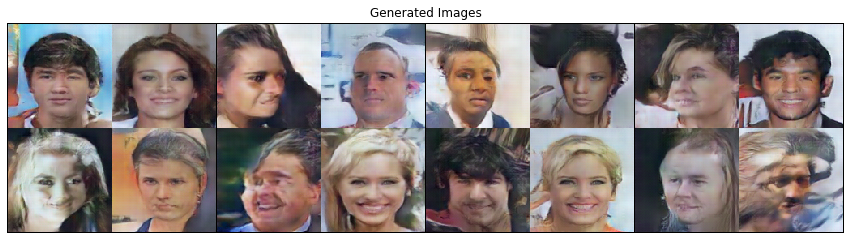

Epoch: (23/30), Batch: (1/2344), D_Loss: 0.4619, G_Loss: 4.0090, D(x): 0.9533, G(D(z)): 0.0694 / 0.0209
Epoch: (23/30), Batch: (501/2344), D_Loss: 0.4954, G_Loss: 2.5908, D(x): 0.7130, G(D(z)): 0.0172 / 0.0861
Epoch: (23/30), Batch: (1001/2344), D_Loss: 0.5609, G_Loss: 1.4416, D(x): 0.6666, G(D(z)): 0.0123 / 0.2729
Epoch: (23/30), Batch: (1501/2344), D_Loss: 0.4704, G_Loss: 4.2778, D(x): 0.9088, G(D(z)): 0.0985 / 0.0133
Epoch: (23/30), Batch: (2001/2344), D_Loss: 0.3938, G_Loss: 4.2752, D(x): 0.9101, G(D(z)): 0.0303 / 0.0123
Epoch: (23/30), Batch: (2344/2344), D_Loss: 0.6287, G_Loss: 4.6530, D(x): 0.9346, G(D(z)): 0.2196 / 0.0088
Epoch: (24/30), Batch: (1/2344), D_Loss: 0.3765, G_Loss: 5.5135, D(x): 0.8636, G(D(z)): 0.0072 / 0.0032
Epoch: (24/30), Batch: (501/2344), D_Loss: 0.3824, G_Loss: 3.6208, D(x): 0.8859, G(D(z)): 0.0332 / 0.0271
Epoch: (24/30), Batch: (1001/2344), D_Loss: 0.5578, G_Loss: 5.4618, D(x): 0.9261, G(D(z)): 0.1436 / 0.0043
Epoch: (24/30), Batch: (1501/2344), D_Loss: 0

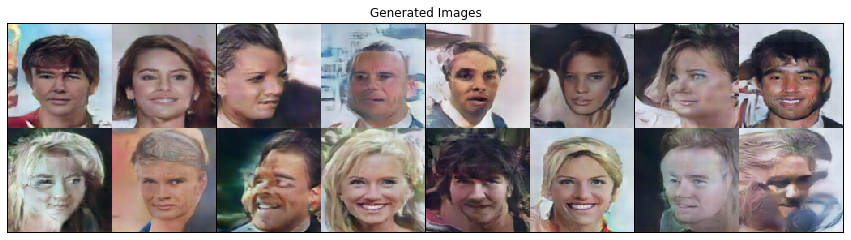

Epoch: (26/30), Batch: (1/2344), D_Loss: 0.5810, G_Loss: 3.9440, D(x): 0.9400, G(D(z)): 0.1840 / 0.0179
Epoch: (26/30), Batch: (501/2344), D_Loss: 0.8170, G_Loss: 1.1302, D(x): 0.5207, G(D(z)): 0.0256 / 0.3425
Epoch: (26/30), Batch: (1001/2344), D_Loss: 0.4652, G_Loss: 3.2881, D(x): 0.7669, G(D(z)): 0.0292 / 0.0419
Epoch: (26/30), Batch: (1501/2344), D_Loss: 0.5460, G_Loss: 3.4706, D(x): 0.6833, G(D(z)): 0.0046 / 0.0303
Epoch: (26/30), Batch: (2001/2344), D_Loss: 0.5957, G_Loss: 3.9169, D(x): 0.9876, G(D(z)): 0.0910 / 0.0213
Epoch: (26/30), Batch: (2344/2344), D_Loss: 0.4014, G_Loss: 4.1620, D(x): 0.9124, G(D(z)): 0.0243 / 0.0150
Epoch: (27/30), Batch: (1/2344), D_Loss: 0.3793, G_Loss: 4.6764, D(x): 0.9358, G(D(z)): 0.0170 / 0.0105
Epoch: (27/30), Batch: (501/2344), D_Loss: 0.6152, G_Loss: 2.8955, D(x): 0.6229, G(D(z)): 0.0083 / 0.0585
Epoch: (27/30), Batch: (1001/2344), D_Loss: 0.4061, G_Loss: 4.9139, D(x): 0.9380, G(D(z)): 0.0336 / 0.0062
Epoch: (27/30), Batch: (1501/2344), D_Loss: 0

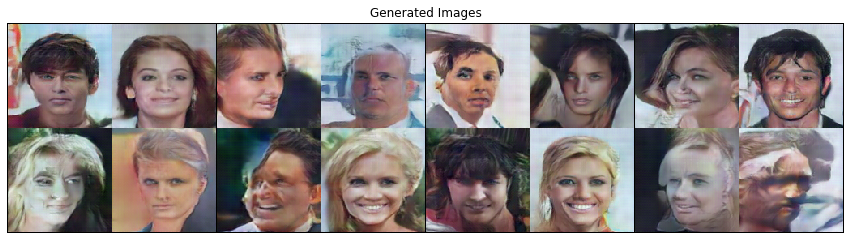

Epoch: (29/30), Batch: (1/2344), D_Loss: 0.3901, G_Loss: 4.5308, D(x): 0.9182, G(D(z)): 0.0348 / 0.0108
Epoch: (29/30), Batch: (501/2344), D_Loss: 0.7028, G_Loss: 5.4840, D(x): 0.9874, G(D(z)): 0.1830 / 0.0033
Epoch: (29/30), Batch: (1001/2344), D_Loss: 0.7598, G_Loss: 3.8257, D(x): 0.9854, G(D(z)): 0.2285 / 0.0202
Epoch: (29/30), Batch: (1501/2344), D_Loss: 0.4384, G_Loss: 5.8979, D(x): 0.8671, G(D(z)): 0.0590 / 0.0022
Epoch: (29/30), Batch: (2001/2344), D_Loss: 0.3762, G_Loss: 3.5248, D(x): 0.8635, G(D(z)): 0.0156 / 0.0303
Epoch: (29/30), Batch: (2344/2344), D_Loss: 0.3888, G_Loss: 3.1744, D(x): 0.8143, G(D(z)): 0.0086 / 0.0401
Epoch: (30/30), Batch: (1/2344), D_Loss: 0.4032, G_Loss: 3.5174, D(x): 0.9382, G(D(z)): 0.0440 / 0.0312
Epoch: (30/30), Batch: (501/2344), D_Loss: 0.3801, G_Loss: 4.4805, D(x): 0.8927, G(D(z)): 0.0237 / 0.0108
Epoch: (30/30), Batch: (1001/2344), D_Loss: 1.5407, G_Loss: 1.7657, D(x): 0.2488, G(D(z)): 0.0005 / 0.2031
Epoch: (30/30), Batch: (1501/2344), D_Loss: 0

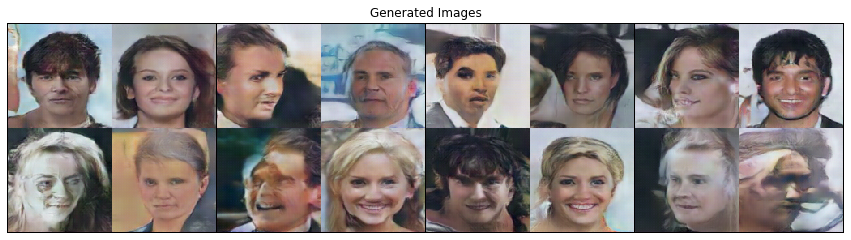

Training Completed!


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [20]:
D = Discriminator().to(device)
G = Generator().to(device)
D.apply(weights_init)
G.apply(weights_init)

if TRAINING_DATA:
    D_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002, betas= (0.5, 0.999))
    G_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))
    error = nn.BCELoss()
    G, D_loss_list, G_loss_list, img_list = train(D, G, D_optimizer, G_optimizer, error, dataloader)
    imageio.mimsave('./gan2.gif', img_list, fps=1)

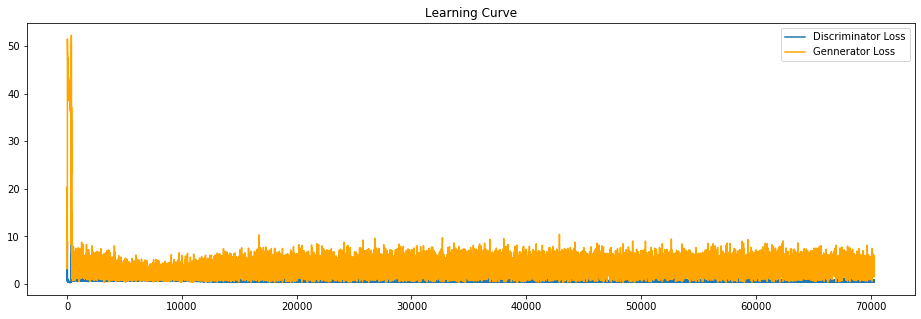

In [21]:
#Plot learning curves
def plot(D_loss_list, G_loss_list, EPOCHS=None):
    if EPOCHS is None:
        EPOCHS = len(D_loss_list)
    fig = plt.figure(figsize=(35,5))
    fig.add_subplot(1,2,1)
    plt.plot(range(EPOCHS), D_loss_list,label = "Discriminator Loss")
    plt.plot(range(EPOCHS),G_loss_list, color ="orange",label = "Gennerator Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()
if TRAINING_DATA: 
    plot(D_loss_list, G_loss_list)

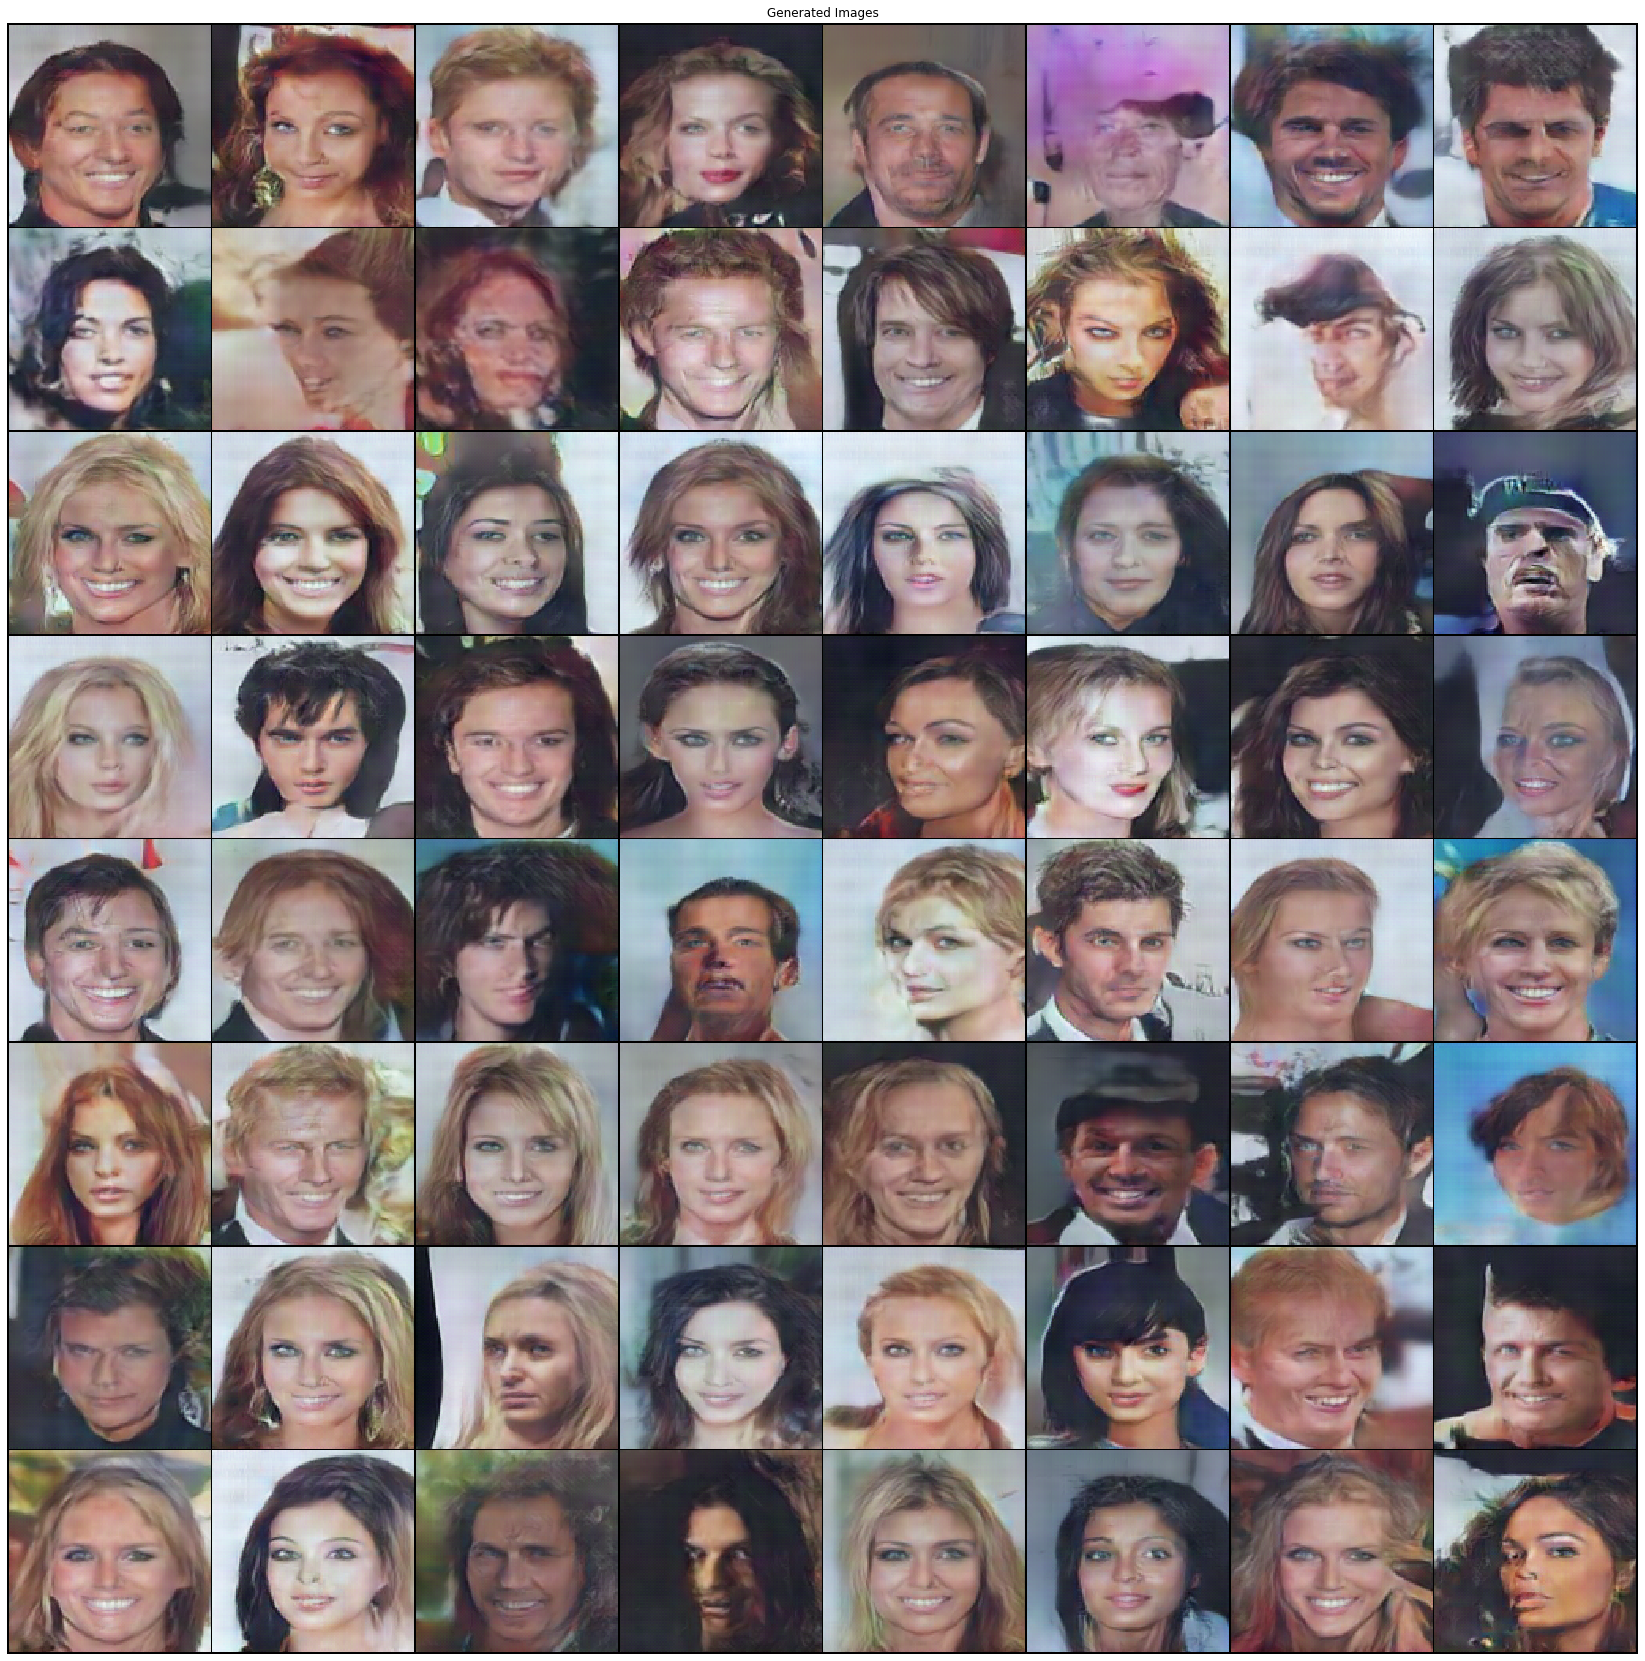

In [65]:
if not TRAINING_DATA:
    G.load_state_dict(torch.load("model/generator-sota.pth"))

#Generate final samples
def visualize_final(NUM_PIC=16):
    test_noise = random_noise(NUM_PIC)
    generate_samples(G, test_noise)
visualize_final(64)